# Four-particle problem

In [1]:
%reload_ext lab_black

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import complex_ode

from quantum_systems import ODQD, GeneralOrbitalSystem
from quantum_systems.time_evolution_operators import TimeEvolutionOperator

from configuration_interaction import CISDTQ, TDCISDTQ
from configuration_interaction.ci_helper import state_printer

from gauss_integrator import GaussIntegrator

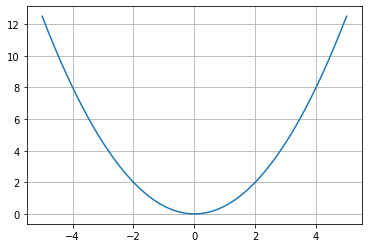

In [3]:
omega = 1

n = 4
l = 4
soft_coulomb = 1
kappa = 1

potential = ODQD.HOPotential(omega=omega)

grid_length = 5
num_grid_points = 2001
grid = np.linspace(-grid_length, grid_length, num_grid_points)

plt.plot(grid, potential(grid))
plt.grid()

plt.show()

In [4]:
system = GeneralOrbitalSystem(
    n,
    ODQD(
        l,
        grid_length,
        num_grid_points,
        a=soft_coulomb,
        alpha=kappa,
        potential=potential,
    ),
)

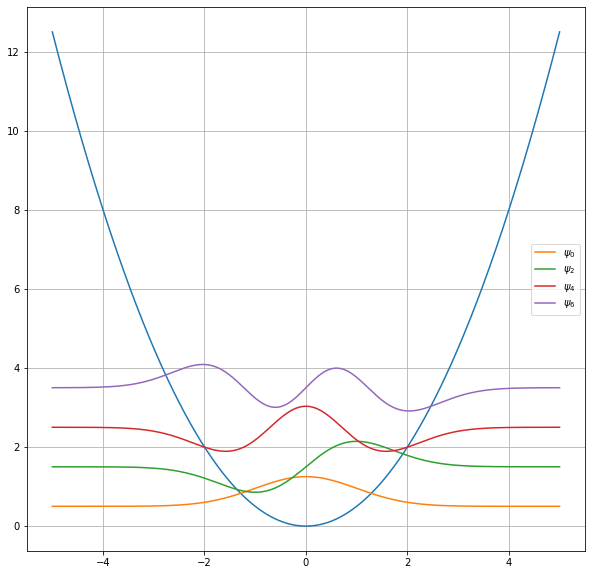

In [5]:
fig = plt.figure(figsize=(10, 10))

plt.plot(grid, potential(grid))

for i in range(0, system.l, 2):
    plt.plot(
        system.grid,
        system.spf[i].real + system.h[i, i].real,
        "-" if i % 2 == 0 else "--",
        label=fr"$\psi_{i}$",
    )

plt.grid()
plt.legend()
plt.show()

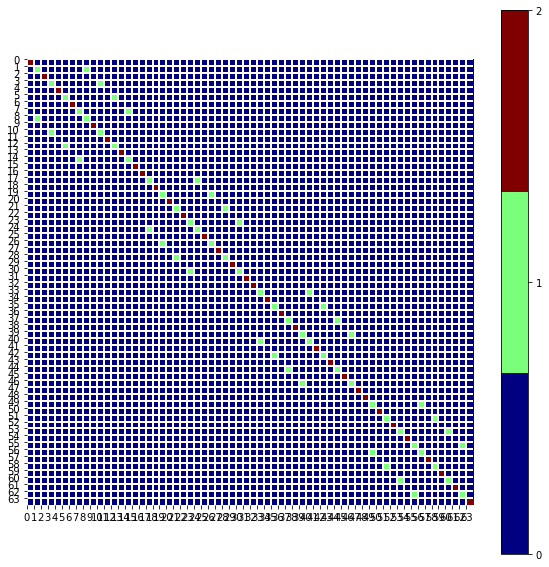

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))

spin_2 = system.spin_2.reshape(int(system.l ** 2), int(system.l ** 2)).real
extent = (0, spin_2.shape[1], spin_2.shape[0], 0)

cmap = plt.get_cmap("jet", np.max(spin_2) - np.min(spin_2) + 1)

mat = ax.imshow(
    spin_2,
    interpolation="none",
    vmin=0,
    vmax=2,
    aspect="equal",
    extent=extent,
    cmap=cmap,
)

fig.colorbar(mat, ax=ax, ticks=np.arange(np.min(spin_2), np.max(spin_2) + 1))

ax.set_xticks(np.arange(0, spin_2.shape[0], 1))
ax.set_yticks(np.arange(0, spin_2.shape[1], 1))

ax.grid(color="w", linewidth=2)
ax.set_frame_on(False)

plt.show()

Hmmm, below we check if the $\hat{S}^2$ matrix varies depending on construction method.

In [8]:
spin_dir_tb_orig = []
spin_dir_tb_pm = []

spin_p = system.spin_x + 1j * system.spin_y
spin_m = system.spin_x - 1j * system.spin_y

for spin in [system.spin_x, system.spin_y, system.spin_z]:
    spin_dir_tb_orig.append(np.kron(spin, system.s) + np.kron(system.s, spin))

for spin in [spin_p, spin_m, system.spin_z]:
    spin_dir_tb_pm.append(np.kron(spin, system.s) + np.kron(system.s, spin))

spin_2 = sum(map(lambda x: x @ x, spin_dir_tb_orig)).reshape(system.spin_2.shape)
spin_2_mp = (
    spin_dir_tb_pm[1] @ spin_dir_tb_pm[0]
    + spin_dir_tb_pm[2]
    + spin_dir_tb_pm[2] @ spin_dir_tb_pm[2]
).reshape(system.spin_2.shape)
spin_2_pm = (
    spin_dir_tb_pm[0] @ spin_dir_tb_pm[1]
    - spin_dir_tb_pm[2]
    + spin_dir_tb_pm[2] @ spin_dir_tb_pm[2]
).reshape(system.spin_2.shape)

np.testing.assert_allclose(spin_2, system.spin_2)
np.testing.assert_allclose(spin_2_mp, system.spin_2)
np.testing.assert_allclose(spin_2_pm, system.spin_2)

In [9]:
cisdtq = CISDTQ(system, verbose=False).compute_ground_state()

In [10]:
print(cisdtq.energies)

[ 7.80767777  8.62466933  8.62466933  8.62466933  8.85863113  9.43911616
  9.43911616  9.43911616  9.44813313  9.64092499  9.64092499  9.64092499
  9.66616832  9.86592447 10.26689495 10.26689495 10.26689495 10.44519955
 10.47990858 10.47990858 10.47990858 10.54278611 10.61063665 10.61063665
 10.61063665 10.83351525 11.08592095 11.08592095 11.08592095 11.08592095
 11.08592095 11.28776239 11.28894268 11.28894268 11.28894268 11.40750358
 11.40750358 11.40750358 11.46792976 11.50545047 11.52292607 11.52292607
 11.52292607 11.7809194  12.09918003 12.09918003 12.09918003 12.2838145
 12.30222031 12.30222031 12.30222031 12.3517844  12.41958969 12.41958969
 12.41958969 12.69318112 13.09224023 13.10425793 13.10425793 13.10425793
 13.28267254 13.28267254 13.28267254 13.29519562 13.56241837 14.08218191
 14.08218191 14.08218191 14.37074209 15.12456721]


In [11]:
print(system.h.real)

[[0.49999922 0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.49999922 0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         1.4999961  0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         1.4999961  0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         2.49998993 0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         2.49998993
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  3.49998169 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         3.49998169]]


In [13]:
dets = []

for i, state in enumerate(cisdtq.states):
    dets.append(f"|{state_printer(state)[52:]}>")
    # print(f"|Phi_{i}> = {dets[-1]}")

In [15]:
eigs = []

for i in range(cisdtq.num_states):
    comb = f"|Psi_{i}> = "
    for j, coeff in enumerate(cisdtq.C[:, i]):
        if abs(coeff) < 1e-10:
            continue

        comb += f"({coeff}){dets[j]}  +  "

    comb = comb[:-5]
    eigs.append(comb)
    # print(comb)
    print(f"|Psi_{i}>")
    print(f"\tE({i}) = {cisdtq.energies[i]:.4f} (eigval)")
    print(f"\tS_z({i}) = {cisdtq._s_z[i]:.4f} (eigval)")
    print(f"\tS^2({i}) = {cisdtq._s_2[i]:.4f} (eigval)")
    print(
        f"\t<Psi_{i}|H|Psi_{i}>  =  {cisdtq.compute_one_body_expectation_value(system.h, K=i).real + 0.5 * cisdtq.compute_two_body_expectation_value(system.u, K=i).real:.4f} (expectation value)"
    )
    print(
        f"\t<Psi_{i}|S_z|Psi_{i}>  =  {cisdtq.compute_one_body_expectation_value(system.spin_z, K=i).real:.4f} (expectation value)"
    )
    print(
        f"\t<Psi_{i}|S^2|Psi_{i}>  =  {cisdtq.compute_two_body_expectation_value(system.spin_2, K=i).real:.4f} (expectation value)"
    )

    S_2_sb = sum(map(lambda x: x @ x, [system.spin_x, system.spin_y, system.spin_z]))
    S_2_sb_exp = cisdtq.compute_one_body_expectation_value(S_2_sb, K=i)
    S_2_tb_exp = cisdtq.compute_two_body_expectation_value(system.spin_2, K=i)
    # print(S_2_sb_exp + 0.25 * S_2_tb_exp)

|Psi_0>
	E(0) = 7.8077 (eigval)
	S_z(0) = 0.0000 (eigval)
	S^2(0) = 6.0000 (eigval)
	<Psi_0|H|Psi_0>  =  7.8077 (expectation value)
	<Psi_0|S_z|Psi_0>  =  -0.0000 (expectation value)
	<Psi_0|S^2|Psi_0>  =  6.0000 (expectation value)
|Psi_1>
	E(1) = 8.6247 (eigval)
	S_z(1) = -1.0000 (eigval)
	S^2(1) = 8.0000 (eigval)
	<Psi_1|H|Psi_1>  =  8.6247 (expectation value)
	<Psi_1|S_z|Psi_1>  =  -1.0000 (expectation value)
	<Psi_1|S^2|Psi_1>  =  8.0000 (expectation value)
|Psi_2>
	E(2) = 8.6247 (eigval)
	S_z(2) = -0.0000 (eigval)
	S^2(2) = 8.0000 (eigval)
	<Psi_2|H|Psi_2>  =  8.6247 (expectation value)
	<Psi_2|S_z|Psi_2>  =  0.0000 (expectation value)
	<Psi_2|S^2|Psi_2>  =  8.0000 (expectation value)
|Psi_3>
	E(3) = 8.6247 (eigval)
	S_z(3) = 1.0000 (eigval)
	S^2(3) = 8.0000 (eigval)
	<Psi_3|H|Psi_3>  =  8.6247 (expectation value)
	<Psi_3|S_z|Psi_3>  =  1.0000 (expectation value)
	<Psi_3|S^2|Psi_3>  =  8.0000 (expectation value)
|Psi_4>
	E(4) = 8.8586 (eigval)
	S_z(4) = -0.0000 (eigval)
	S^2(4) =

E_0 = 4.4989  | <d_0> = 0.00000
	Dipole allowed 0 -> 1: [(-1.648789847896619e-16+0j)]
	Dipole allowed 0 -> 2: [(-0.09065059809879214+0j)]
	Dipole allowed 0 -> 3: [(-1.9866017800807353e-16+0j)]
	Dipole allowed 0 -> 4: [(1.1281456189708783+0j)]
	Dipole allowed 0 -> 5: [(9.604059466338216e-17+0j)]
	Dipole allowed 0 -> 6: [(-5.3614843329128853e-17+0j)]
	Dipole allowed 0 -> 7: [(-1.821066172840039e-18+0j)]
	Dipole allowed 0 -> 8: [(5.39806567406007e-16+0j)]
	Dipole allowed 0 -> 9: [(-6.966002584114077e-17+0j)]
	Dipole allowed 0 -> 10: [(-5.585454617713596e-13+0j)]
	Dipole allowed 0 -> 11: [(-3.910951569781641e-16+0j)]
	Dipole allowed 0 -> 12: [(-1.7362743771415905e-13+0j)]
	Dipole allowed 0 -> 13: [(-7.024390034188768e-16+0j)]
	Dipole allowed 0 -> 14: [(-0.0027182405723522813+0j)]
	Dipole allowed 0 -> 15: [(1.1321972928158254e-15+0j)]
	Dipole allowed 0 -> 16: [(0.01632693842233762+0j)]
	Dipole allowed 0 -> 17: [(4.587113705236799e-16+0j)]
	Dipole allowed 0 -> 18: [(2.5519412180344044e-14+0j

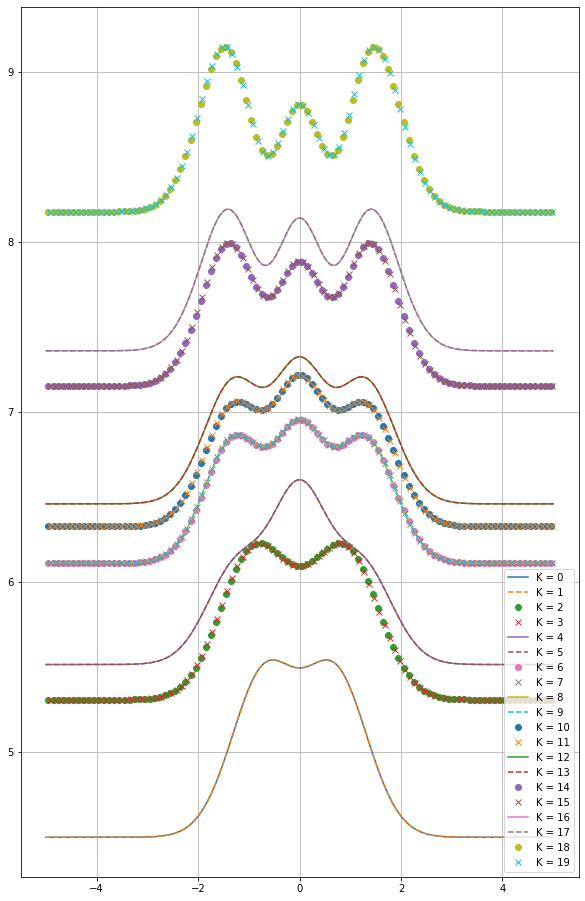

In [13]:
fig = plt.figure(figsize=(10, 16))

for I in range(min(cisdt.num_states, 20)):
    dip = cisdt.compute_one_body_expectation_value(system.dipole_moment[0], K=I)
    print(fr"E_{I} = {cisdt.energies[I]:.4f}  | <d_{I}> = {dip.real:.5f}")
    for J in range(I + 1, min(cisdt.num_states, 20)):
        print(f"\tDipole allowed {I} -> {J}: {cisdt.allowed_dipole_transition(I, J)}")
    rho_I = cisdt.compute_particle_density(K=I).real

    fmt = ["-", "--", "o", "x"]
    plt.plot(
        system.grid,
        rho_I + cisdt.energies[I].real,
        fmt[I % 4],
        label=fr"K = {I}",
        markevery=np.arange(len(system.grid))[I % 4 * 5 :: 20],
    )
    print(f"\t(int) dx rho_{I}(x) = {np.trapz(rho_I, system.grid)}")

plt.grid()
plt.legend(loc="lower right")
plt.show()